# Project notebook **<span style="COLOR:BLACK">Tennis Grand Slam Statistics 2013</span>**


### Student 1 (first half presentation)
Name : Diederik Ketellapper
<br>Group : Intermediate
### Student 2 (second half presentation)
Name : Eric Brea Garcia
<br>Group : Intermediate
### Data name : Tennis Major Tournament Match Statistics
### Data URL : https://archive.ics.uci.edu/ml/datasets/Tennis+Major+Tournament+Match+Statistics
### Short summary of the project and datasource :

The goal of this project is to predict the gender of a tennis player from the match stats of 2013 Grand Slam Tournaments, and along the way showcase the Python skills learned during this course.

In order to do so we are going to use the a collection of datasets from the UCI database with the grand slam matches statistics for 2013. There are 8 datasets, one per Grand Slam and Gender.

### Aims : 
** <span style="color:black"> The aims in preprocessing are the following:</span> ** 
* Merge the 8 datasets into a unique dataset with new columns for tournament and Gender. The issues are that the columns and players names accross the different datasets are not spelled in the same manner.
* The dataset has a lot of missing data which should be imputed.
* Create a new players data set with the stats corresponding to each player per match, for estimation purposes.

** <span style="color:black"> The aims in the visualization are the following:</span> **
* Show if the main statistics in tennis (Aces, Break Points and Unforced Errors) are comparable between surfaces, gender and rounds.

** <span style="color:black"> The aims in the estimation are the following:</span> **
* Perform a logistic regression and try to predict whether a player is male or female.

### Download : 
** <span style="color:black">Our data is divided into 8 different datasets, one per Grand Slam and per Gender.</span> ** 
* The datasets can be retrieved from the above provided URL, first goal is to download them.
* Then we will merge it into a unique dataset and append a column for sexes and for the different tournaments.

In [1]:
# The first step is to load the general packages we are going to use:
import sys

import numpy as np
import pandas as pd

# More specific packages will be loaded when necessary.

In [2]:
import urllib.request as ur
import zipfile
import glob

# Downloading the data:
print('Downloading data...')
data_file = 'Tennis-Major-Tournaments-Match-Statistics.zip'
ur.urlretrieve ("https://archive.ics.uci.edu/ml/machine-learning-databases/00300/Tennis-Major-Tournaments-Match-Statistics.zip", data_file)
print('Download complete.')

# Unzip the files into a datasets folder:
with zipfile.ZipFile(data_file, 'r') as zip_ref :
    zip_ref.extractall('datasets')

# Open the files with pandas and merge appending the tournament and Gender column:
file_list = glob.glob('datasets/*.csv')

dfs = [] # Initialize empty list
for file in file_list :
    df = pd.read_csv(file)
    df['Tournament'] = file.split('\\')[1].split('-')[0]
    df['Gender'] = file.split('-')[1]
    dfs.append(df)
print('Files opened succesfully.')

Download complete.
Files opened succesfully.


Now that we have loaded the datasets with the new columns we are going to do the following checks:
* Are they composed of the same match statistics?
* Are the variables spelled in the same manner?
* And the players' names?

In [3]:
# First we check the number of columns and rows:
for df in dfs:
    print(len(df.columns))
    print(len(df.index))

44
126
44
127
44
125
44
127
44
126
44
76
44
114
44
122


We can see that the number of columns is the same but the number of matches played varys for each grand slam.
Now we are going to check if all the columns have the same label, and if it differs take as reference the one used in the first dataset:

In [4]:
# Here we are going to compare the first df labels with the rest, and see if there is any misspelling:
control_names = dfs[0].columns

for df in dfs[1:8] : # for each df in dfs
    for i in range(0,len(df.columns)) : # for each column name in df
        if df.columns[i] != control_names[i]: # If not like contol name 
            wrong_name = df.columns[i] # Save wrong name for reporting purposes
            df.rename(columns = {str(df.columns[i]): str(control_names[i])}, inplace = True) # Replace by the correct name
            print("The following label", wrong_name,"was changed for", df.columns[i])

The following label FNL.1 was changed for FNL1
The following label FNL.2 was changed for FNL2
The following label FNL.1 was changed for FNL1
The following label FNL.2 was changed for FNL2
The following label Player 1 was changed for Player1
The following label Player 2 was changed for Player2
The following label ROUND was changed for Round
The following label FNL.1 was changed for FNL1
The following label FNL.2 was changed for FNL2
The following label ST2.1.1 was changed for ST1.2
The following label FNL.1 was changed for FNL1
The following label FNL.2 was changed for FNL2
The following label FNL.1 was changed for FNL1
The following label FNL.2 was changed for FNL2
The following label ST1.1.1 was changed for ST1.2


We have found 15 cases of the same label spelled in a different way and standarized them. Now we can merge it into a unique dataframe.

In [5]:
# Now we are going to merge it in one unique dataframe:
gs_matches = pd.concat(dfs, ignore_index = True)

Now we are going to standarize the players names since they have been stored in a different way in each dataset:

In [6]:
import re

# We create a numpy array with all the players names to ease the standarization process:
matches_player1=list((gs_matches['Player1']))
matches_player2=list(gs_matches['Player2'])
playerlist_dirty=np.array(matches_player1+matches_player2)

# Here we match the names by its similarity and store them under the same name:
playerlist_clean=np.empty(len(playerlist_dirty),dtype='U50') # Initialize numpy array to store standarized names.
for i in range(0,len(playerlist_dirty)):

    first_letter=playerlist_dirty[i][0] # Take first letter
    names_split=re.split('\W',playerlist_dirty[i]) # Split the name into their different words
    last_name=names_split[-1] # Take last word (the last name)
    search_value='^'+first_letter+'.'+'*'+last_name+'$' # Build RegEx, match on first letter and last word with something in between
    if first_letter+last_name=='XXXX': # If name already checked go to the next one
        continue
        
    find_idx = [i for i, item in enumerate(playerlist_dirty) if re.search(search_value, item)] # Find the indexes of matched names
    longest_name=max(playerlist_dirty[find_idx]) # Find the longest name
    value=[longest_name]*len(find_idx) # Create array with new cleaned up names
    removes=['XXX XXX']*len(find_idx) # Create signifying values to be put in dirty array
    np.put(playerlist_clean,ind=find_idx,v=value) # Put new names in new array
    np.put(playerlist_dirty,ind=find_idx,v=removes) # Put signifying values in old array so we don't check them again
print('Done')

Done


Let's check some of the changes we have done:

In [7]:
playerlist_old=np.array(matches_player1+matches_player2)
playername_changes=playerlist_clean!=playerlist_old
total_changes=sum(playername_changes) 
changed_names=np.column_stack((playerlist_clean[playername_changes],playerlist_old[playername_changes]))
print(changed_names[-5:])

[['Na Li' 'N.Li']
 ['Kaia Kanepi' 'K.Kanepi']
 ['Kirsten Flipkens' 'K.Flipkens']
 ['Agnieszka Radwanska' 'A.Radwanska']
 ['Marion Bartoli' 'M.Bartoli']]


Here we put the names into the dataframe:

In [8]:
# Now we split the player list we were working with into Player 1 and Player 2 again:
half_length=int(len(playerlist_clean)/2)
matches_player1_new=playerlist_clean[:half_length]
matches_player2_new=playerlist_clean[half_length:]

# We substitute it in the gs_matches dataframe:
gs_matches['Player1'] = matches_player1_new
gs_matches['Player2'] = matches_player2_new

print(gs_matches[-5:])

                 Player1              Player2  Round  Result  FNL1  FNL2  \
938  Agnieszka Radwanska                Na Li      5       1   2.0   1.0   
939       Sabine Lisicki          Kaia Kanepi      5       1   2.0   0.0   
940       Marion Bartoli     Kirsten Flipkens      6       1   2.0   0.0   
941       Sabine Lisicki  Agnieszka Radwanska      6       1   2.0   1.0   
942       Sabine Lisicki       Marion Bartoli      7       0   0.0   2.0   

     FSP.1  FSW.1  SSP.1  SSW.1   ...    NPA.2  NPW.2  TPW.2  ST1.2  ST2.2  \
938     77     52     23      9   ...     71.0   48.0    NaN    6.0    6.0   
939     59     26     41     10   ...     19.0    9.0    NaN    3.0    3.0   
940     61     21     39     10   ...     21.0    8.0    NaN    1.0    2.0   
941     63     53     37     19   ...     31.0   16.0    NaN    4.0    6.0   
942     65     22     35      9   ...     11.0    9.0    NaN    6.0    6.0   

     ST3.2  ST4.2  ST5.2  Tournament  Gender  
938    2.0    NaN    NaN   

### Data charaterisctics :  Here, give as much as possible characteristics of data
** <span style="color:black"> Here we are gonna try to get an insight in the dataset and it's characteristics:</span> ** 
* Display the merged dataset to get an idea of what it looks like.
* Display some stats about our dataset.
* Check how the variables are stored and optimize the memory they are using.
* Check if there is missing data, although it will be handled in the next sections.

In [9]:
# First a little bit of displaying to know more about the stats provided:
print(gs_matches.head())
print(gs_matches.tail())

            Player1          Player2  Round  Result  FNL1  FNL2  FSP.1  FSW.1  \
0       Lukas Lacko   Novak Djokovic      1       0   0.0   3.0     61     35   
1    Leonardo Mayer  Albert Montanes      1       1   3.0   0.0     61     31   
2  Marcos Baghdatis    Denis Istomin      1       0   0.0   3.0     52     53   
3   Dmitry Tursunov  Michael Russell      1       1   3.0   0.0     53     39   
4       Juan Monaco   Ernests Gulbis      1       0   1.0   3.0     76     63   

   SSP.1  SSW.1   ...    NPA.2  NPW.2  TPW.2  ST1.2  ST2.2  ST3.2  ST4.2  \
0     39     18   ...      8.0    9.0  101.0    6.0    7.0    6.0    NaN   
1     39     13   ...      NaN    NaN   42.0    1.0    3.0    1.0    NaN   
2     48     20   ...     12.0   16.0  126.0    6.0    7.0    6.0    NaN   
3     47     24   ...      NaN    NaN   79.0    2.0    2.0    3.0    NaN   
4     24     12   ...     16.0   28.0  127.0    1.0    6.0    7.0    6.0   

   ST5.2  Tournament  Gender  
0    NaN     AusOpen     

We can see that our merged dataset is composed of the information of all the 2013 grand slam matches. The first 2 columns correspond to each player in the match, the third to which round of the tournament was, the fourth the match outcome, and the rest 40 columns correspond to different match statistics (20 for each player).

In [10]:
# And let's display some stats about the dataset:
print(gs_matches.describe())

            Round      Result        FNL1        FNL2       FSP.1       FSW.1  \
count  943.000000  943.000000  942.000000  942.000000  943.000000  943.000000   
mean     1.844115    0.493107    1.490446    1.492569   62.256628   38.785790   
std      1.254328    0.500218    1.156883    1.173316    7.921985   17.486747   
min      1.000000    0.000000    0.000000    0.000000   38.000000    3.000000   
25%      1.000000    0.000000    0.000000    0.000000   57.000000   26.000000   
50%      1.000000    0.000000    2.000000    2.000000   62.000000   37.000000   
75%      2.000000    1.000000    2.000000    3.000000   67.000000   49.000000   
max      7.000000    1.000000    3.000000    3.000000   86.000000  109.000000   

            SSP.1       SSW.1       ACE.1       DBF.1    ...           BPC.2  \
count  943.000000  943.000000  921.000000  935.000000    ...      942.000000   
mean    37.785790   16.729586    6.140065    3.641711    ...        5.209130   
std      7.917886    8.607756 

We can see all the numerical variables described, the remaining 4 variables are text. Now let's check the type of each varibale:

In [11]:
# We check the types of the columns:
gs_matches.dtypes

Player1        object
Player2        object
Round           int64
Result          int64
FNL1          float64
FNL2          float64
FSP.1           int64
FSW.1           int64
SSP.1           int64
SSW.1           int64
ACE.1         float64
DBF.1         float64
WNR.1         float64
UFE.1         float64
BPC.1         float64
BPW.1         float64
NPA.1         float64
NPW.1         float64
TPW.1         float64
ST1.1         float64
ST2.1         float64
ST3.1         float64
ST4.1         float64
ST5.1         float64
FSP.2           int64
FSW.2           int64
SSP.2           int64
SSW.2           int64
ACE.2         float64
DBF.2         float64
WNR.2         float64
UFE.2         float64
BPC.2         float64
BPW.2         float64
NPA.2         float64
NPW.2         float64
TPW.2         float64
ST1.2         float64
ST2.2         float64
ST3.2         float64
ST4.2         float64
ST5.2         float64
Tournament     object
Gender         object
dtype: object

We can see that the the longest number stored is 230, so there is no need for using type int/float64, thus we are going to change it for uint8 and float16 respectively.

Regarding the categorical variables, the type is object which is not very convinient compared to str.

In [12]:
print(sys.getsizeof(gs_matches))

555312


In [13]:
# Now we change the numerical variables from int/float64 to int/float16, and the categorical to str:
for col in gs_matches.columns :
    if gs_matches[col].dtype == 'int64' :
        gs_matches[col] = gs_matches[col].astype('uint8')
    elif gs_matches[col].dtype == 'float64' :
        gs_matches[col] = gs_matches[col].astype('float16')
    else :
        gs_matches[col] = gs_matches[col].astype('str')
# As a result, the footprint of the data set in data has been reduced:
print(sys.getsizeof(gs_matches))

319562


Now we are going to print the number of NAs in our dataset per variable:

In [14]:
# We are going to print the number of NAs in our dataset per variable:
print(gs_matches.isnull().sum())

Player1         0
Player2         0
Round           0
Result          0
FNL1            1
FNL2            1
FSP.1           0
FSW.1           0
SSP.1           0
SSW.1           0
ACE.1          22
DBF.1           8
WNR.1         126
UFE.1         126
BPC.1           1
BPW.1           1
NPA.1          84
NPW.1          83
TPW.1         312
ST1.1           1
ST2.1           4
ST3.1         321
ST4.1         722
ST5.1         857
FSP.2           0
FSW.2           0
SSP.2           0
SSW.2           0
ACE.2          22
DBF.2           8
WNR.2         126
UFE.2         126
BPC.2           1
BPW.2           1
NPA.2          84
NPW.2          83
TPW.2         312
ST1.2           1
ST2.2           4
ST3.2         321
ST4.2         722
ST5.2         857
Tournament      0
Gender          0
dtype: int64


The NAs are going to be handled appropiately in the next section.

### Data consistency checking

As we have seen in the previous section we have missing data in our dataset, we are going to explore it and impute it.

** Final Number of games won NAs **

We will start with the final number of games won by player, where a single value is missing.

In [15]:
# We retrieve the match with the NAs, in that case there is only one:
fnl_nan=gs_matches['FNL1'].isnull()
gs_matches[fnl_nan].T

,170
Player1,Alize Cornet
Player2,Polona Hercog
Round,1
Result,0
FNL1,NaN
FNL2,NaN
FSP.1,75
FSW.1,3
SSP.1,25
SSW.1,1


We have found in the media that:

"Hercog began her season at the Australian Open. In the first round, she was up against 25th seed Alizé Cornet. Hercog retired trailing 1-0 due to a shoulder injury".

So we are just going to drop this match from the dataset:

In [16]:
gs_matches.drop(gs_matches[fnl_nan].index, inplace = True)

** ACEs NAs **

So here we check the Aces it was curious that we had 22 Aces for Aces of 1 and Aces 2. Indeed it seems that they occur in the same matches where we believe that the aces were not recorded.

In [17]:
ace1_nan=gs_matches['ACE.1'].isnull()
ace2_nan=gs_matches['ACE.2'].isnull()
ace_nan= np.logical_or(ace1_nan,ace2_nan)
gs_matches[ace_nan].T

,140,181,220,233,237,382,383,396,397,409,...,422,436,439,458,462,494,832,858,878,906
Player1,Sachia Vickery,Lourdes Dominguez Lino,Bojana Jovanovski,Alize Cornet,Yvonne Meusburger,Karin Knapp,Vania King,Irina-Camelia Begu,Alize Cornet,Na Li,...,Urszula Radwanska,Petra Cetkovska,Monica Niculescu,Yulia Putintseva,Mathilde Johansson,Carla Suarez Navarro,Carla Suarez Navarro,Maria-Teresa Torro-Flor,Olga Puchkova,Agnieszka Radwanska
Player2,Lauren Davis,Caroline Wozniacki,Yvonne Meusburger,Maria Sharapova,Victoria Azarenka,Sloane Stephens,Aravane Rezai,Silvia Soler-Espinosa,Maria Joao Koehler,Anabel Medina Garrigues,...,Venus Williams,Olga Puchkova,Johanna Larsson,Sara Errani,Ana Ivanovic,Sara Errani,Lourdes Dominguez Lino,Irina-Camelia Begu,Arantxa Rus,Mathilde Johansson
Round,1,1,2,3,3,1,1,1,1,1,...,1,1,1,2,2,4,1,1,1,2
Result,0,0,0,0,0,0,1,0,1,1,...,1,1,0,0,0,0,1,1,1,1
FNL1,0,0,1,0,0,0,2,0,2,2,...,2,2,0,0,0,1,2,2,2,2
FNL2,2,2,2,2,2,2,0,2,0,0,...,1,0,2,2,2,2,0,0,0,0
FSP.1,51,58,69,65,70,57,74,74,70,71,...,68,69,82,64,73,67,68,72,69,62
FSW.1,14,10,30,24,8,18,27,26,28,31,...,48,25,15,11,17,32,27,25,24,23
SSP.1,49,42,31,35,30,43,26,26,30,29,...,32,31,18,36,27,33,32,28,31,38
SSW.1,12,8,14,9,4,13,11,6,11,7,...,16,8,4,5,4,14,14,8,4,12


So here we have to choose what to do, just removing the rows does not seem like a good idea. The choice we have to make is how we are going to impute then, we could do a couple of different things here: Impute by 0: Most seem to be in female tennis where zero aces are lot more common than in male tennis, it could be that the data was incorrectly recorded as NaN when it was actualy zero. Impute by the mean of aces Impute by the mean of aces but according to sex as we can see clearly here that most have a bias by sex and thus they are definitely not independent by sex.

In [18]:
# We impute by the mean differentiating between Men and Women:
gs_matches['ACE.1'].fillna(gs_matches.groupby("Gender")["ACE.1"].transform("mean"), inplace=True)
gs_matches['ACE.2'].fillna(gs_matches.groupby("Gender")["ACE.2"].transform("mean"), inplace=True)

gs_matches[ace_nan].T

,140,181,220,233,237,382,383,396,397,409,...,422,436,439,458,462,494,832,858,878,906
Player1,Sachia Vickery,Lourdes Dominguez Lino,Bojana Jovanovski,Alize Cornet,Yvonne Meusburger,Karin Knapp,Vania King,Irina-Camelia Begu,Alize Cornet,Na Li,...,Urszula Radwanska,Petra Cetkovska,Monica Niculescu,Yulia Putintseva,Mathilde Johansson,Carla Suarez Navarro,Carla Suarez Navarro,Maria-Teresa Torro-Flor,Olga Puchkova,Agnieszka Radwanska
Player2,Lauren Davis,Caroline Wozniacki,Yvonne Meusburger,Maria Sharapova,Victoria Azarenka,Sloane Stephens,Aravane Rezai,Silvia Soler-Espinosa,Maria Joao Koehler,Anabel Medina Garrigues,...,Venus Williams,Olga Puchkova,Johanna Larsson,Sara Errani,Ana Ivanovic,Sara Errani,Lourdes Dominguez Lino,Irina-Camelia Begu,Arantxa Rus,Mathilde Johansson
Round,1,1,2,3,3,1,1,1,1,1,...,1,1,1,2,2,4,1,1,1,2
Result,0,0,0,0,0,0,1,0,1,1,...,1,1,0,0,0,0,1,1,1,1
FNL1,0,0,1,0,0,0,2,0,2,2,...,2,2,0,0,0,1,2,2,2,2
FNL2,2,2,2,2,2,2,0,2,0,0,...,1,0,2,2,2,2,0,0,0,0
FSP.1,51,58,69,65,70,57,74,74,70,71,...,68,69,82,64,73,67,68,72,69,62
FSW.1,14,10,30,24,8,18,27,26,28,31,...,48,25,15,11,17,32,27,25,24,23
SSP.1,49,42,31,35,30,43,26,26,30,29,...,32,31,18,36,27,33,32,28,31,38
SSW.1,12,8,14,9,4,13,11,6,11,7,...,16,8,4,5,4,14,14,8,4,12


** Double Fault Errors NAs **

We can see that the missing values for the stat DBF.X are always in the same match, thus we have matches missing this stat. Note that there are 7 and not 8 as listed above, because the match deleted previously also fell into that category.

In [19]:
dbf1_nan=gs_matches['DBF.1'].isnull()
dbf2_nan=gs_matches['DBF.2'].isnull()
dbf_nan= np.logical_or(dbf1_nan,dbf2_nan)
gs_matches[dbf_nan].T

,8,309,316,444,454,503,770
Player1,David Guez,Simone Bolelli,Somdev Devvarman,Vania King,Ashleigh Barty,Serena Williams,Novak Djokovic
Player2,Richard Gasquet,Yen-Hsun Lu,Roger Federer,Sloane Stephens,Maria Kirilenko,Sara Errani,Florian Mayer
Round,1,1,2,2,2,6,1
Result,0,0,0,0,0,1,1
FNL1,0,0,0,0,0,2,3
FNL2,3,3,3,2,1,0,0
FSP.1,64,63,61,82,61,52,63
FSW.1,26,33,19,17,6,14,41
SSP.1,36,37,39,18,39,48,37
SSW.1,12,12,16,6,4,14,26


Now we are going to impute them by the mean:

In [20]:
# We impute by the mean differentiating between Men and Women:
gs_matches['DBF.1'].fillna(gs_matches.groupby("Gender")["DBF.1"].transform("mean"), inplace=True)
gs_matches['DBF.2'].fillna(gs_matches.groupby("Gender")["DBF.2"].transform("mean"), inplace=True)

gs_matches[dbf_nan].T

,8,309,316,444,454,503,770
Player1,David Guez,Simone Bolelli,Somdev Devvarman,Vania King,Ashleigh Barty,Serena Williams,Novak Djokovic
Player2,Richard Gasquet,Yen-Hsun Lu,Roger Federer,Sloane Stephens,Maria Kirilenko,Sara Errani,Florian Mayer
Round,1,1,2,2,2,6,1
Result,0,0,0,0,0,1,1
FNL1,0,0,0,0,0,2,3
FNL2,3,3,3,2,1,0,0
FSP.1,64,63,61,82,61,52,63
FSW.1,26,33,19,17,6,14,41
SSP.1,36,37,39,18,39,48,37
SSW.1,12,12,16,6,4,14,26


** Winners and Unforced Errors NAs**

It's curious that for the Winners (WNR.X) and Unforced errors (UFE.X) stats the number of NAs is the same, for that reason we are going to threat them together.

In [21]:
# Here we print the NAs for the Winners and Unforced errors to see if we can infere the cause and impute them:
wnr1_nan=gs_matches['WNR.1'].isnull()
wnr2_nan=gs_matches['WNR.2'].isnull()
ufe1_nan=gs_matches['UFE.1'].isnull()
ufe2_nan=gs_matches['UFE.2'].isnull()
wnr_and_ufe_nan= np.logical_or.reduce([wnr1_nan,wnr2_nan,ufe1_nan,ufe2_nan])
gs_matches[wnr_and_ufe_nan].T

,505,506,507,508,509,510,511,512,513,514,...,621,622,623,624,625,626,627,628,629,630
Player1,Richard Gasquet,Stephane Robert,Jan-Lennard Struff,Aljaz Bedene,Feliciano Lopez,Kenny De Schepper,Andrey Kuznetsov,Pablo Cuevas,Ernests Gulbis,Mikhail Kukushkin,...,Mikhail Youzhny,Andy Murray,Stanislas Wawrinka,Richard Gasquet,Tommy Robredo,Novak Djokovic,Andy Murray,Novak Djokovic,Richard Gasquet,Novak Djokovic
Player2,Michael Russell,Aravane Rezai,Guillaume Rufin,Dmitry Tursunov,Florent Serra,Bradley Klahn,Dudi Sela,Janko Tipsarevic,Andreas Haider-Maurer,Aravane Rezai,...,Lleyton Hewitt,Denis Istomin,Tomas Berdych,David Ferrer,Rafael Nadal,Mikhail Youzhny,Stanislas Wawrinka,Stanislas Wawrinka,Rafael Nadal,Rafael Nadal
Round,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Result,1,1,0,0,1,0,0,0,0,1,...,1,1,1,1,0,1,0,1,0,0
FNL1,3,3,2,1,3,1,2,1,2,3,...,3,3,3,3,0,3,0,3,0,1
FNL2,0,0,3,3,1,3,3,2,3,0,...,2,1,1,2,3,1,3,2,3,3
FSP.1,63,61,55,52,58,59,53,51,58,51,...,59,63,58,59,52,68,63,67,64,68
FSW.1,45,44,61,41,54,68,59,39,68,35,...,55,58,55,57,20,49,37,64,41,40
SSP.1,37,39,45,48,42,41,47,49,42,49,...,41,37,42,41,48,32,37,33,36,32
SSW.1,16,19,32,19,30,37,44,24,31,27,...,29,23,27,31,9,19,22,25,15,16


We have 126 matches wit missing data in those variables, and it seems that we have no data available for these stats for the Men's '13 US Open.

In [22]:
# We check the above hypothesis:
matches_usopen=gs_matches['Tournament'] == 'USOpen'
matches_male=gs_matches['Gender'] == 'men'
matches_usopen_male=np.logical_and(matches_usopen,matches_male)
number_matches_usopen=len(gs_matches[matches_usopen_male])
print(number_matches_usopen)

126


We are going to search for this information on the web and impute it:

In [23]:
print('Downloading data...')
matches_players_us2013_id ='2013-usopen-matches.csv'
matches_data_us2013= '2013-usopen-points.csv'
url_matches_players_us2013_id='https://raw.githubusercontent.com/JeffSackmann/tennis_slam_pointbypoint/master/2013-usopen-matches.csv'
url_matches_data_us2013= 'https://raw.githubusercontent.com/JeffSackmann/tennis_slam_pointbypoint/master/2013-usopen-points.csv'
ur.urlretrieve (url_matches_players_us2013_id, matches_players_us2013_id)
ur.urlretrieve (url_matches_data_us2013, matches_data_us2013)
print('Download complete.')

Download complete.


Now we have to merge the two datasets that we found on the internet containing the missing data:

In [24]:
us_open_ids = pd.read_table(matches_players_us2013_id, sep=',', 
             usecols=['match_id','player1','player2'])
us_open_matches= pd.read_table(matches_data_us2013, sep=',', 
             usecols=['match_id','P1UnfErr','P2UnfErr','P1Winner','P2Winner'])
us_open_matches_grouped=us_open_matches.groupby('match_id').sum().reset_index()
us_matches_found=pd.merge(us_open_ids,us_open_matches_grouped,on='match_id')

## Prepare for merging
us_matches_found.rename(columns={'player1':'Player1','player2':'Player2',
                                 'P1Winner': 'WNR.1','P2Winner':'WNR.2',
                                 'P1UnfErr':'UFE.1', 'P2UnfErr': 'UFE.2'}, inplace=True)
del us_matches_found['match_id']
us_matches_found[:5]

,Player1,Player2,WNR.1,WNR.2,UFE.1,UFE.2
0,Novak Djokovic,Ricardas Berankis,28,16,9,27
1,Benoit Paire,Alex Bogomolov Jr.,86,39,68,41
2,Tim Smyczek,James Duckworth,32,24,39,71
3,Rajeev Ram,Fabio Fognini,24,25,18,31
4,Tommy Haas,Paul-Henri Mathieu,38,24,13,26


Now we first merge the data into the usopen dataframe. Afterwards now that the indices will match we can run a for loop and impute the data. 

In [25]:
old_usopen=gs_matches[matches_usopen_male].copy()
old_usopen=old_usopen.T.drop(['WNR.1','WNR.2','UFE.1','UFE.2']).T
usopenmen_clean=pd.merge(old_usopen,us_matches_found,on=['Player1','Player2'],how='left')

first_index=gs_matches[matches_usopen_male]

for i in range(0,len(usopenmen_clean)):
    gs_matches.loc[505+i,"UFE.1"]=usopenmen_clean.loc[i,"UFE.1"]
    gs_matches.loc[505+i,"UFE.2"]=usopenmen_clean.loc[i,"UFE.2"]
    gs_matches.loc[505+i,"WNR.1"]=usopenmen_clean.loc[i,"WNR.1"]
    gs_matches.loc[505+i,"WNR.2"]=usopenmen_clean.loc[i,"WNR.2"]
gs_matches[matches_usopen_male][:5].T

,505,506,507,508,509
Player1,Richard Gasquet,Stephane Robert,Jan-Lennard Struff,Aljaz Bedene,Feliciano Lopez
Player2,Michael Russell,Aravane Rezai,Guillaume Rufin,Dmitry Tursunov,Florent Serra
Round,1,1,1,1,1
Result,1,1,0,0,1
FNL1,3,3,2,1,3
FNL2,0,0,3,3,1
FSP.1,63,61,55,52,58
FSW.1,45,44,61,41,54
SSP.1,37,39,45,48,42
SSW.1,16,19,32,19,30


We have managed to impute almost all of the NAs with the missing values, but we are still missing some of them. We have reduced the NAs from 126 to 40 in each stats.

In [26]:
gs_matches.isnull().sum()

Player1         0
Player2         0
Round           0
Result          0
FNL1            0
FNL2            0
FSP.1           0
FSW.1           0
SSP.1           0
SSW.1           0
ACE.1           0
DBF.1           0
WNR.1          40
UFE.1          40
BPC.1           0
BPW.1           0
NPA.1          84
NPW.1          83
TPW.1         312
ST1.1           0
ST2.1           3
ST3.1         320
ST4.1         721
ST5.1         856
FSP.2           0
FSW.2           0
SSP.2           0
SSW.2           0
ACE.2           0
DBF.2           0
WNR.2          40
UFE.2          40
BPC.2           0
BPW.2           0
NPA.2          84
NPW.2          83
TPW.2         312
ST1.2           0
ST2.2           3
ST3.2         320
ST4.2         721
ST5.2         856
Tournament      0
Gender          0
dtype: int64

We impute the other NAs by the mean:

In [27]:
gs_matches['WNR.1'].fillna(gs_matches.groupby("Gender")["WNR.1"].transform("mean"), inplace=True)
gs_matches['WNR.2'].fillna(gs_matches.groupby("Gender")["WNR.2"].transform("mean"), inplace=True)

gs_matches['UFE.1'].fillna(gs_matches.groupby("Gender")["UFE.1"].transform("mean"), inplace=True)
gs_matches['UFE.2'].fillna(gs_matches.groupby("Gender")["UFE.2"].transform("mean"), inplace=True)

** Brake Points NAs **

Here we are going to deal with the break points stats missing values, which are BPC.X and BPW.X. In this case the only missing value has already been delated since it belonged to the match deleted above.

** Net Points NAs **

Here we are going to deal with the net points stats missing values, which are NPA.X and NPW.X.


In [28]:
# Here we print the NAs for the Winners and Unforced errors to see if we can infere the cause and impute them:
npa1_nan=gs_matches['NPA.1'].isnull()
npa2_nan=gs_matches['NPA.2'].isnull()
npw1_nan=gs_matches['NPW.1'].isnull()
npw2_nan=gs_matches['NPW.2'].isnull()
npa_and_npw_nan= np.logical_or.reduce([npa1_nan,npa2_nan,npw1_nan,npw2_nan])
gs_matches[npa_and_npw_nan].T

,1,3,9,14,17,21,25,26,27,29,...,570,574,575,583,586,590,591,596,679,694
Player1,Leonardo Mayer,Dmitry Tursunov,Nikolay Davydenko,Alejandro Falla,Steve Johnson,Albert Ramos,Carlos Berlocq,Dominic Thiem,Kevin Anderson,Jan Hajek,...,Guillaume Rufin,Dudi Sela,Andreas Haider-Maurer,Ivan Dodig,Jarkko Nieminen,Alexandr Dolgopolov,Evgeny Donskoy,Tobias Kamke,Ashleigh Barty,Agnieszka Radwanska
Player2,Albert Montanes,Michael Russell,Lukasz Kubot,Mikhail Kukushkin,Adrian Mannarino,Pablo Andujar,Edouard Roger-Vasselin,Joao Sousa,Jiri Vesely,Damir Dzumhur,...,Dmitry Tursunov,Janko Tipsarevic,Mikhail Kukushkin,Nikolay Davydenko,Joao Sousa,Mikhail Youzhny,Peter Gojowczyk,Denis Istomin,Anastasia Pavlyuchenkova,Silvia Soler-Espinosa
Round,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
Result,1,1,1,1,0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,1
FNL1,3,3,3,3,2,0,1,3,3,0,...,0,0,0,3,2,0,3,0,0,2
FNL2,0,0,2,1,3,3,3,1,2,3,...,2,3,3,0,3,3,2,3,2,0
FSP.1,61,53,77,60,53,61,57,55,63,73,...,43,62,60,66,64,53,55,46,52,72
FSW.1,31,39,76,50,50,32,49,60,76,31,...,14,30,45,45,65,35,63,19,13,26
SSP.1,39,47,23,40,47,39,43,45,37,27,...,57,38,40,34,36,47,45,54,48,28
SSW.1,13,24,11,23,28,10,32,31,28,6,...,12,10,17,14,25,19,34,23,10,6


Now we are going to impute them by the mean:

In [29]:
gs_matches['NPA.1'].fillna(gs_matches.groupby("Gender")["NPA.1"].transform("mean"), inplace=True)
gs_matches['NPA.2'].fillna(gs_matches.groupby("Gender")["NPA.2"].transform("mean"), inplace=True)

gs_matches['NPW.1'].fillna(gs_matches.groupby("Gender")["NPW.1"].transform("mean"), inplace=True)
gs_matches['NPW.2'].fillna(gs_matches.groupby("Gender")["NPW.2"].transform("mean"), inplace=True)

gs_matches[npa_and_npw_nan].T

,1,3,9,14,17,21,25,26,27,29,...,570,574,575,583,586,590,591,596,679,694
Player1,Leonardo Mayer,Dmitry Tursunov,Nikolay Davydenko,Alejandro Falla,Steve Johnson,Albert Ramos,Carlos Berlocq,Dominic Thiem,Kevin Anderson,Jan Hajek,...,Guillaume Rufin,Dudi Sela,Andreas Haider-Maurer,Ivan Dodig,Jarkko Nieminen,Alexandr Dolgopolov,Evgeny Donskoy,Tobias Kamke,Ashleigh Barty,Agnieszka Radwanska
Player2,Albert Montanes,Michael Russell,Lukasz Kubot,Mikhail Kukushkin,Adrian Mannarino,Pablo Andujar,Edouard Roger-Vasselin,Joao Sousa,Jiri Vesely,Damir Dzumhur,...,Dmitry Tursunov,Janko Tipsarevic,Mikhail Kukushkin,Nikolay Davydenko,Joao Sousa,Mikhail Youzhny,Peter Gojowczyk,Denis Istomin,Anastasia Pavlyuchenkova,Silvia Soler-Espinosa
Round,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,2,1
Result,1,1,1,1,0,0,0,1,1,0,...,0,0,0,1,0,0,1,0,0,1
FNL1,3,3,3,3,2,0,1,3,3,0,...,0,0,0,3,2,0,3,0,0,2
FNL2,0,0,2,1,3,3,3,1,2,3,...,2,3,3,0,3,3,2,3,2,0
FSP.1,61,53,77,60,53,61,57,55,63,73,...,43,62,60,66,64,53,55,46,52,72
FSW.1,31,39,76,50,50,32,49,60,76,31,...,14,30,45,45,65,35,63,19,13,26
SSP.1,39,47,23,40,47,39,43,45,37,27,...,57,38,40,34,36,47,45,54,48,28
SSW.1,13,24,11,23,28,10,32,31,28,6,...,12,10,17,14,25,19,34,23,10,6


** Set Results NAs **

In that case the missing values that we find are due to that the GS tournaments are played to the best of 3 sets for women and to the best of 5 for men. As a result there are not NAs in the first two sets results (excpet the case of 3 WDs), and in the 3rd set the NAs will correspond to women's matches that didn't make it to the third set to untie. In the case of the 4th and 5th sets all the women matches will have a NA, and also the men's matches that didn't make it that far.

We are gonna leave the NAs for this variables since they are completely logical and we are not going use them for estimation purposes since they desvirtuate the estimation itself. 

** Total Points Won NAs **

Let's explore how are the TPW are missing and if we can identify any pattern:

In [30]:
tpw1_nan=gs_matches['TPW.1'].isnull()
tpw2_nan=gs_matches['TPW.2'].isnull()
tpw_nan= np.logical_or(tpw1_nan,tpw2_nan)
gs_matches[tpw_nan].T

,631,632,633,634,635,636,637,638,639,640,...,933,934,935,936,937,938,939,940,941,942
Player1,Serena Williams,Flavia Pennetta,Serena Williams,Roberta Vinci,Daniela Hantuchova,Ekaterina Makarova,Ana Ivanovic,Alison Riske,Simona Halep,Camila Giorgi,...,Agnieszka Radwanska,Laura Robson,Serena Williams,Petra Kvitova,Sloane Stephens,Agnieszka Radwanska,Sabine Lisicki,Marion Bartoli,Sabine Lisicki,Sabine Lisicki
Player2,Victoria Azarenka,Victoria Azarenka,Na Li,Flavia Pennetta,Victoria Azarenka,Na Li,Victoria Azarenka,Daniela Hantuchova,Flavia Pennetta,Roberta Vinci,...,Tsvetana Pironkova,Kaia Kanepi,Sabine Lisicki,Kirsten Flipkens,Marion Bartoli,Na Li,Kaia Kanepi,Kirsten Flipkens,Agnieszka Radwanska,Marion Bartoli
Round,7,6,6,5,5,5,4,4,4,4,...,4,4,4,5,5,5,5,6,6,7
Result,1,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,1,1,1,0
FNL1,2,0,2,0,0,1,1,1,0,0,...,2,0,1,1,0,2,2,2,2,0
FNL2,1,2,0,2,2,2,2,2,2,2,...,1,2,2,2,2,1,0,0,1,2
FSP.1,57,44,63,60,58,60,55,69,75,54,...,71,57,62,72,63,77,59,61,63,65
FSW.1,44,12,26,21,14,40,26,37,22,18,...,47,32,31,50,24,52,26,21,53,22
SSP.1,43,56,37,40,42,40,45,31,25,46,...,29,43,38,28,37,23,41,39,37,35
SSW.1,20,7,9,7,5,18,18,14,8,11,...,17,16,16,11,5,9,10,10,19,9


In that case this stat (TPW.X) is missing for the Women's US Open, and all Wimbeldon matches.

In [31]:
# We check the above hypothesis:
matches_wimbledon = gs_matches['Tournament'] == 'Wimbledon'
matches_usopen=gs_matches['Tournament'] == 'USOpen'
matches_women= gs_matches['Gender'] == 'women'
matches_usopen_women=np.logical_and(matches_usopen,matches_women)

print(matches_usopen_women.sum() + matches_wimbledon.sum())

312


In this case due to on the amount of missing data, the difficulty to retrieve it from the internet, and the fact it's not important for our estimation goals because of the difference in sets between men and women. We have decided to drop this column.

In [32]:
del gs_matches['TPW.1']
del gs_matches['TPW.2']

** Conclusion **

As a result of the imputation process we have the following:

In [33]:
gs_matches.isnull().sum()

Player1         0
Player2         0
Round           0
Result          0
FNL1            0
FNL2            0
FSP.1           0
FSW.1           0
SSP.1           0
SSW.1           0
ACE.1           0
DBF.1           0
WNR.1           0
UFE.1           0
BPC.1           0
BPW.1           0
NPA.1           0
NPW.1           0
ST1.1           0
ST2.1           3
ST3.1         320
ST4.1         721
ST5.1         856
FSP.2           0
FSW.2           0
SSP.2           0
SSW.2           0
ACE.2           0
DBF.2           0
WNR.2           0
UFE.2           0
BPC.2           0
BPW.2           0
NPA.2           0
NPW.2           0
ST1.2           0
ST2.2           3
ST3.2         320
ST4.2         721
ST5.2         856
Tournament      0
Gender          0
dtype: int64

### Data visualisation and representation
<span style="color:black"> In order to present relevant visualizations for the posterior estiamtion task we are going to create a new dataset from the merged one with the average stats per match per player. The aims of this section are:</span>
* Create a players dataframe with the average stats per match per player.
* Plot the relevant stats across Gender to see it's relevance
* Plot the relevant stats across Tournament

The first thing to do will be to create the Players' stats dataset:

In [34]:
gs_matches.columns

Index(['Player1', 'Player2', 'Round', 'Result', 'FNL1', 'FNL2', 'FSP.1',
       'FSW.1', 'SSP.1', 'SSW.1', 'ACE.1', 'DBF.1', 'WNR.1', 'UFE.1', 'BPC.1',
       'BPW.1', 'NPA.1', 'NPW.1', 'ST1.1', 'ST2.1', 'ST3.1', 'ST4.1', 'ST5.1',
       'FSP.2', 'FSW.2', 'SSP.2', 'SSW.2', 'ACE.2', 'DBF.2', 'WNR.2', 'UFE.2',
       'BPC.2', 'BPW.2', 'NPA.2', 'NPW.2', 'ST1.2', 'ST2.2', 'ST3.2', 'ST4.2',
       'ST5.2', 'Tournament', 'Gender'],
      dtype='object')

In [35]:
# Create two data frames each one with the player corresponding statistics depending on if he played the match as local or visitor:
ply1_stats_ind = [0,2,3,4,41] + list(range(6,18))
players1 = gs_matches.iloc[:,ply1_stats_ind].copy() # If you don't put copy it's not a new object, just references a slice of the original object

ply2_stats_ind = [1,2,3,5,41] + list(range(24,36))
players2 = gs_matches.iloc[:,ply2_stats_ind].copy()
players2['Result'].replace(to_replace = [0,1], value = [1,0], inplace = True) # Since Result is referenced to player 1

# Rename the columns and concatenate to obtain a unique dataset:
players1.columns = players2.columns = ['Player','Round','Result','FNL', 'Gender','FSP','FSW','SSP','SSW','ACE','DBF','WNR','UFE','BPC','BPW','NPA','NPW']
players = pd.concat([players1, players2], ignore_index = True)

# Group statistics and compute it's the appropiate operation:
players = players.groupby('Player').agg({'Round': max, 'Result': sum, 'FNL': sum, 'Gender': max,'FSP': np.mean, 'FSW': np.mean, 'SSP': np.mean, 'SSW': np.mean, 'ACE': np.mean, 'DBF': np.mean, 'WNR': np.mean, 'UFE': np.mean,'BPC': np.mean,'BPW': np.mean,'NPA': np.mean,'NPW': np.mean})

print('We can see that we have a total of', len(players),'participants in the 2013 Grand Slams')

players[:5]

We can see that we have a total of 337 participants in the 2013 Grand Slams


,Round,Result,FNL,Gender,FSP,FSW,SSP,SSW,ACE,DBF,WNR,UFE,BPC,BPW,NPA,NPW
Player,,,,,,,,,,,,,,,,
Adrian Mannarino,4,5,20.0,men,51.555556,47.222222,32.222222,17.562500,5.777344,15.929688,28.421875,26.671875,6.332031,16.937500,23.953125,17.000000
Adrian Ungur,1,0,1.0,men,57.500000,30.500000,42.500000,16.500000,1.500000,6.000000,22.500000,34.000000,1.500000,1.500000,15.500000,14.000000
Agnieszka Radwanska,6,16,33.0,women,63.263158,32.263158,30.210526,10.734375,2.306641,3.000000,20.421875,13.265625,7.527344,8.789062,16.312500,18.265625
Albert Montanes,2,1,4.0,men,51.800000,31.800000,25.200000,8.398438,4.601562,16.203125,23.312500,16.593750,4.601562,9.140625,16.078125,10.085938
Albert Ramos,1,0,2.0,men,58.750000,44.750000,41.250000,21.250000,5.750000,4.250000,24.500000,26.750000,3.500000,7.250000,18.015625,22.109375


Now we are going to focus on the three main statistics in tennis: aces (ACE), brakes (BPC and BPW) and unforced errors (UFE):

** ACEs **

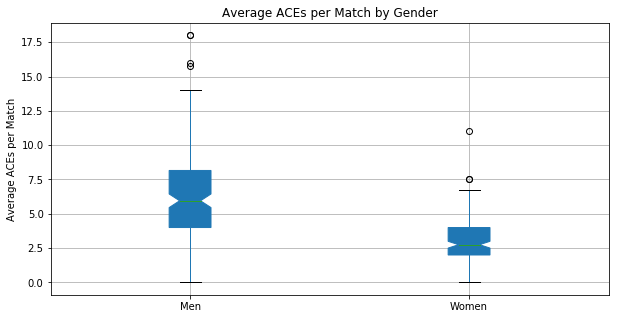

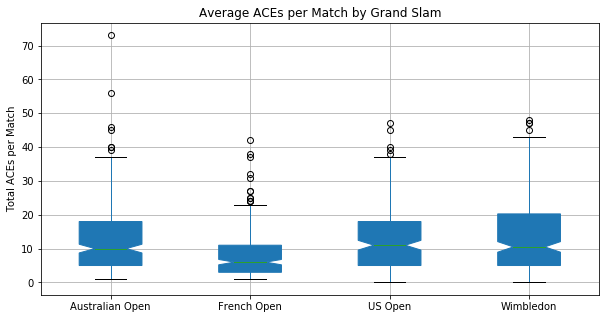

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

# Regarding the number of aces:
fig1 = plt.subplots(figsize = (10, 5))
data1 = players[['Gender','ACE']].groupby('Gender')

bplot1 = data1.boxplot(data1,vert = True, notch = True, patch_artist = True)
plt.setp(bplot1, xticklabels = ['Men','Women'])
bplot1.set_ylabel('Average ACEs per Match')
bplot1.set_title('Average ACEs per Match by Gender')

fig2 = plt.subplots(figsize = (10, 5))
data2 = gs_matches[['Tournament']].copy()
data2['ACE'] = gs_matches['ACE.1'] + gs_matches['ACE.2']
data2 = data2.groupby('Tournament')

bplot2 = data2.boxplot(data2, vert = True, notch = True, patch_artist = True)
plt.setp(bplot2, xticklabels = ['Australian Open','French Open', 'US Open','Wimbledon'])
bplot2.set_ylabel('Total ACEs per Match')
bplot2.set_title('Average ACEs per Match by Grand Slam')

We can see that there is a difference between the average number of ACEs that men and women achieve. Also we can see that for the slower surface played in GS (clay in Roland Garros) the average number of ACEs is slightly inferior which makes sense.

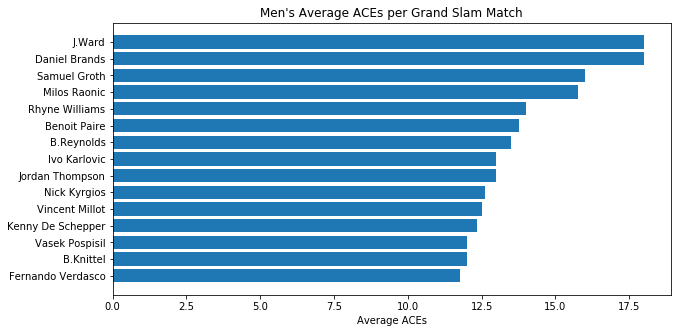

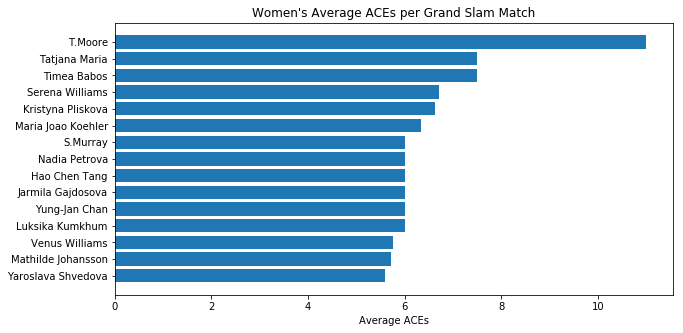

In [37]:
# Lets plot the average of ACEs per male player
fig3, ax = plt.subplots(figsize = (10, 5))
data3 = players[players.Gender == 'men'].sort_values('ACE', ascending = False)[:15] # Top 15 aces achievers in men's GS
data3 = data3['ACE']
ply = list(data3.index)
y_pos = np.arange(len(ply))

ax.barh(y_pos, list(data3))
plt.yticks(y_pos, ply)
ax.set_title('Men\'s Average ACEs per Grand Slam Match')
ax.set_xlabel('Average ACEs')
ax.invert_yaxis()

# Lets plot the average of ACEs per female player
fig4, ax = plt.subplots(figsize = (10, 5))
data4 = players[players.Gender == 'women'].sort_values('ACE', ascending = False)[:15] # Top 15 aces achievers in women's GS
data4 = data4['ACE']
ply = list(data4.index)
y_pos = np.arange(len(ply))

ax.barh(y_pos, list(data4))
plt.yticks(y_pos, ply)
ax.set_title('Women\'s Average ACEs per Grand Slam Match')
ax.set_xlabel('Average ACEs')
ax.invert_yaxis()

** Brake Points **

Regarding the brakes we have two different statistics Brake Points Created (BPC) and Break Points Won (BPW).

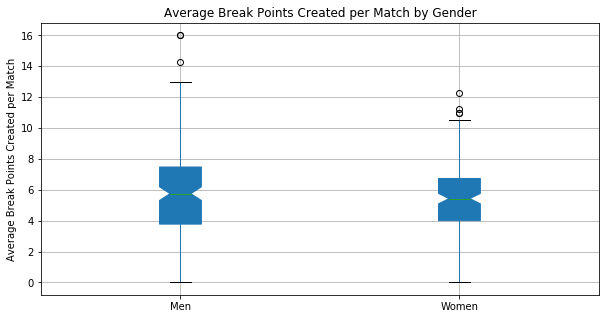

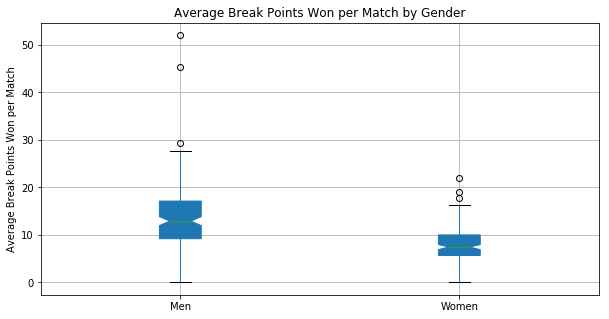

In [38]:
# Regarding Break Points Created:
fig5 = plt.subplots(figsize = (10, 5))
data5 = players[['Gender','BPC']].groupby('Gender')

bplot3 = data5.boxplot(data3,vert = True, notch = True, patch_artist = True)
plt.setp(bplot3, xticklabels = ['Men','Women'])
bplot3.set_ylabel('Average Break Points Created per Match')
bplot3.set_title('Average Break Points Created per Match by Gender')

# Regarding the Break Points Won:
fig6 = plt.subplots(figsize = (10, 5))
data6 = players[['Gender','BPW']].groupby('Gender')

bplot4 = data6.boxplot(data3,vert = True, notch = True, patch_artist = True)
plt.setp(bplot4, xticklabels = ['Men','Women'])
bplot4.set_ylabel('Average Break Points Won per Match')
bplot4.set_title('Average Break Points Won per Match by Gender')


We can see that there is almost no difference in the amount of Break Points generated by Gender, but it's is in the number of Break Points won.

** Unforced Errors **

The number of unforced errors is a key statistic in Tennis, let's see if it varys between men and women:

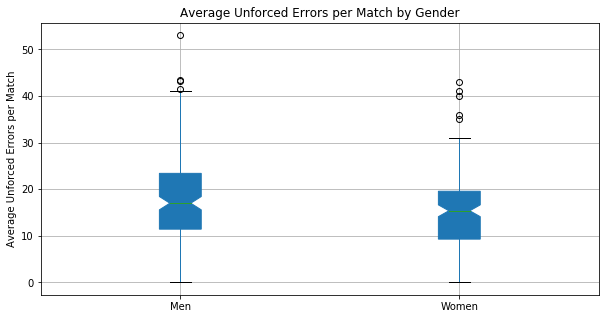

In [39]:
fig7 = plt.subplots(figsize = (10, 5))
data7 = players[['Gender','UFE']].groupby('Gender')

bplot5 = data7.boxplot(data5,vert = True, notch = True, patch_artist = True)
plt.setp(bplot5, xticklabels = ['Men','Women'])
bplot5.set_ylabel('Average Unforced Errors per Match')
bplot5.set_title('Average Unforced Errors per Match by Gender')

There is no significant difference between the average unforced errors per match between men and women. Let's see if we can approximate the effect of pressure, by plotting the average unforced errors per round:

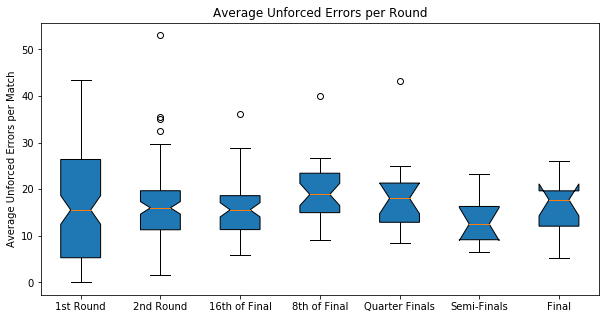

In [40]:
# Let's see if the unforced errors grow with the number of rounds played for the Grand Slam winners in 2013:
gs_rounds = []
for i in range(1,8) :
    df = players[players.Round == i]['UFE']
    gs_rounds.append(df)

fig8,ax = plt.subplots(figsize = (10, 5))

ax.boxplot(gs_rounds,vert = True, notch = True, patch_artist = True)
plt.xticks(range(1,8), ['1st Round', '2nd Round','16th of Final', '8th of Final', 'Quarter Finals', 'Semi-Finals','Final'])
ax.set_ylabel('Average Unforced Errors per Match')
ax.set_title('Average Unforced Errors per Round')

We obtain a courious behavior, that can be explained since the players getting into Quarter finals usually make less unforced errors in average, producing this behavior.

### Estimation question
<span style="color:black"> In this estimation section we are going to try to predict the gender of a player based on thier overall stats in the Grand Slam matches of '13. We are going to do so by first doing a Wald test on all the variables and afterwards implementing a logistic regression.</span> 

In [41]:
# Copy original created dataframe
final_data=players.copy()

# First we have to convert our variables so that we can use them with the packages we will use:
columns_possible=['Result','FNL','FSP','FSW','SSP','SSW','ACE','DBF','WNR','UFE','BPC','BPW','NPA','NPW']
x_possible=final_data[columns_possible].astype(float) 
y=np.where(final_data['Gender'] == "men", 1, 0)

# We use a stats model package here to do the wald test and check which variables 
# we might use to predict a male or female based on their average stats in the grand slam games.

import statsmodels.api as sm
logit_model=sm.Logit(y,x_possible)
result=logit_model.fit()
print(result.summary())



C:\Users\Eric\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.229651
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  337
Model:                          Logit   Df Residuals:                      323
Method:                           MLE   Df Model:                           13
Date:                Wed, 17 Jan 2018   Pseudo R-squ.:                  0.6684
Time:                        20:02:06   Log-Likelihood:                -77.392
converged:                       True   LL-Null:                       -233.41
                                        LLR p-value:                 7.255e-59
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Result        -2.3917      0.529     -4.524      0.000      -3.428      -1.356
FNL            0.8466      0.

Lets choose all the possible values from the Wald test with p-value smaller than 0.05. Result and FNL would be a bit unfair to chose (as women play less games than men(because they play 3 sets instead of 5) and so are less interesting to predict with.

In [42]:
columns_chosen=['SSP','SSW','BPC','NPW']
x_chosen=final_data[columns_chosen].astype(float)

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## This functions splits up our data to train on and data to do the predictions on.
x_train, x_test, y_train, y_test = train_test_split(x_chosen, y, test_size=0.3, random_state=0)
logreg = LogisticRegression() 
logreg.fit(x_train, y_train) # Fit on training
y_pred = logreg.predict(x_test) 
print(logreg.score(x_test, y_test))

C:\Users\Eric\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


0.862745098039


We can quite accurately predict whether the player is male or female. We could run some more reports such as a confusion matrix which we do below but many functions are available from sklearn(roc curve etc).

In [43]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix) 

[[44  3]
 [11 44]]
